## Pitch Predict: English Premier League Match Results Prediction

## Introduction

In this project, we compare the performance of many Machine Learning and Deep Learning strategies and models to predict the outcomes of English Premier League soccer matches based on the average player performance of both teams from the previous season (mormalized by minutes played). We have two targets for prediction: the result (Home Win, Away Win, or Draw), as well as the Goal Difference for the home team (home goals - away goals). This allows us to perform both classification and regression, to have a greater chance at discovering the best predictor model possible.

The goal is to have the best model (that is within our means to achieve) to **predict the result of an EPL match based only on the team sheets (player list) for the Home and Away teams.** This could be useful for betting, fantasy sports, or other applications where predicting the outcome of a match based on limited, but fast and readily available information is important.

Both traditional machine learning and basic deep learning techniques will be used. To ensure a rigorous assessment, we will employ pipelines for hyperparameter tuning, and k-fold cross-validation for validating model performance. We will also create different neural network models, such as a basic fully connected NN, an Tabular CNN, or other neural network strategies, and compare their accuracy metrics. This methodology will give us an exhaustive exploration of a wide array of models for the selection of a model that best captures the match outcomes.

### Data Sources
*Click to follow links.*

Match Statistics: [matches.jsonl](https://www.kaggle.com/datasets/hugomathien/soccer/data) and [players.csv](https://www.kaggle.com/datasets/hugomathien/soccer/data)

Player Statistics: [All Files in player_statistics folder](https://www.kaggle.com/datasets/davidantonioteixeira/premier-league-player-statistics-1992-2022?resource=download)


### Training Data Construction

The datasets downloaded from the links above each contain part of, but not the entire, data required for training a machine learning model for our purposes. The `matches.jsonl` file contains match data, while the `players.csv` file contains information to map player names with player ids. The player statistics files contain player data, but separated across different seasons and for different statistics.

The dataset construction process involves several key steps: merging player data, merging match data, mapping player names to IDs, and finally creating a unified dataset for ML training. Each step is encapsulated in a Python script, executed sequentially to ensure data integrity and alignment.

**Merging Player Data `(merge_player_data.py)`**

Individual CSV files containing player statistics are read from the ./player_statistics directory one at a time in a for loop.
Columns not relevant to the analysis ('Rank', 'Club', 'Nationality') are removed.
A unified DataFrame is created by merging individual DataFrames on 'Initial Year' and 'Player'. 'Initial Year' is the year the for which the player statistics are calculated - it represents the start of the Premier League season. However, since we want to predict match results based on player stats from the previous season, we need to align the player data with the match data accordingly. 
- <span style = "color:blue"> This is achieved by adding 1 to all values in the initial year column. </span> This way, the player data for what was originally the 2020 season is now aligned with the match data for the 2021 season, and so on.
- <span style="color:blue">Missing 'Minutes Played' values are filled with the column mean.</span>
- <span style="color:blue">All statistics are normalized by minutes played for each player.</span>

**Merging Match Data `(merge_match_data.py)`**

The script reads a JSONL file (matches.jsonl), dropping entries not pertaining to the English league (`league == en`). For each line in the input file, the script reads and parses the JSON object representing a match's statistics. It constructs a row for each match that includes the match ID, year, home and away goals, and identifiers for every player (starting and substitutes) from both home and away teams. These rows are written to the output CSV file, effectively transforming and merging the JSON Lines data into a structured CSV format to merge with player data above.

**Map Players to Matches `(map_player_to_id.py)`**

The players in player_data are identified using names, and for match data, they are identified using numerical IDs. This script maps player names to player IDs. The players.csv contains the names and IDs of players, but some are referred only by their nicknames. This script matches either full names or nicknames to player IDs.

**Create Training Data `(create_final_csv.py)`**

The final step in the data construction process is to merge the player and match data. The script gathers all players for either team and calculates the mean value for each statistic across all players for that team based on their *previous* season. The final csv file contains the features Average_Home_Goals_Per_Minute_Played, Average_Away_Assists_Per_Minute_Played, etc. for each match along with the final match result (Home Win, represented as 1, Away Win, represented as -1, and Draw, represented as 0). In hindsight, the mapping should have been 0, 1, and 2. This is fixed below. The Home Goal Difference is also calculated as the difference between home and away goals. We have 2 target vectors (only one will be used for each model, obviously). But we now can compare performance of classification versus regression.

# 1. Classification Models

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset, random_split
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

### 1.1 Data Splitting


In [61]:
# A custom dataset class is used here. It inherits from the pytorch Dataset class.
# This class is used to make it easier to use pytortch's DataLoaders, as well as to handle the data througout the creation of multiple different models.

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [62]:
# Load and prepare the data
# The values -1, 0, and 1 for classification labels are not compatible with PyTorch, so we remap them to 0, 1, and 2.
# Home Gaol Difference is not used in this section, as that will later be used as a new target to create regression models.
data = pd.read_csv('final_dataset.csv')
X = data.drop(['Match ID', 'Result', 'Home Goal Difference'], axis=1).values
y = data['Result'].map({-1: 0, 0: 1, 1: 2}).values  # Convert class labels from -1, 0, 1 to 0, 1, 2

# Split into train+val and test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then split train+val into train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

# Scale features (fit on training data, then transform train, val, and test sets)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

# Create datasets
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
val_dataset = CustomDataset(X_val_tensor, y_val_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

# Data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


### 1.2 Initialization and Training of Models

In [63]:
from sklearn.metrics import accuracy_score

**Fully Connected Neural Network**

In [64]:
# We create an FCNN class that will define the structure of our Fully Connected Neural Network.
# The FCNN has a property called 'input_size', instead of hardcoding it to be the number of features in the dataset.
# This was done as we wanted to experiment with different sets of player statistics.

class FCNN(nn.Module):
    def __init__(self, input_size):
        super(FCNN, self).__init__()         # The input size will be determined when the model is created
        self.fc1 = nn.Linear(input_size, 64) # 64 neurons in the first hidden layer
        self.fc2 = nn.Linear(64, 32)         # 32 neurons in the second hidden layer
        self.fc3 = nn.Linear(32, 3)          # 3 neurons in the output layer, one for Home Win, Draw, and Away Win

    def forward(self, x):                    # The forward function defines the forward pass of the model.
        x = torch.relu(self.fc1(x))          # The activation function used is ReLU for all hiudden layers.
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)                      # No activation function is applied to the output layer.
                                             # Softmax can be used to get the probabilities for each class, had we more time to improve this experiment.
        return x

In [65]:
# The following are functions created to allow repeated training and validation of our different pytorch models.
# This can be reused for different models and datasets based on the model and loader parameters.

def train(model, criterion, optimizer, loader):
    model.train()
    running_loss = 0.0

    # The training loop
    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(loader)

def validate(model, loader):
    model.eval()
    predictions, truths = [], []

    # The validation loop
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            truths.extend(labels.cpu().numpy())
            
    accuracy = accuracy_score(truths, predictions)
    return accuracy

In [66]:
best_val_accuracy = 0.0
best_model_state = None

model = FCNN(input_size=X.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101): # We will train for 100 epochs

    # Train and validate at every epoch
    train_loss = train(model, criterion, optimizer, train_loader)
    val_accuracy = validate(model, val_loader)

    # Check if the current model's validation accuracy is the best, and save if it is currently the best one
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict()
        print(f"Epoch {epoch} : New best model saved with validation accuracy: {best_val_accuracy:.4f}")

torch.save(best_model_state, './models/fcnn_classification_best.pth')

Epoch 1 : New best model saved with validation accuracy: 0.5026
Epoch 2 : New best model saved with validation accuracy: 0.5316
Epoch 3 : New best model saved with validation accuracy: 0.5526
Epoch 6 : New best model saved with validation accuracy: 0.5553


**Convolutional Neural Network**

In [67]:
class TabularCNN(nn.Module):
    def __init__(self, num_features):
        super(TabularCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # A max pooling layer to reduce the dimensionality of the feature maps,
        # using a kernel size of 2 and stride of 2, with no padding. This helps in reducing overfitting.
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        def calculate_conv_output_size(input_size, kernel_size=3, stride=1, padding=1, pool_kernel=2, pool_stride=2):
            # After convolution
            output_size = (input_size - kernel_size + 2 * padding) / stride + 1
            # After pooling
            output_size = (output_size - pool_kernel) / pool_stride + 1
            return int(output_size)

        # The size of the feature vector expected by the first fully connected layer
        size_after_first_conv = calculate_conv_output_size(num_features)
        size_after_second_conv = calculate_conv_output_size(size_after_first_conv)

        feature_size_after_conv = size_after_second_conv * 32

        self.fc1 = nn.Linear(feature_size_after_conv, 64)

        # The second FC layer reduces the feature dimension to just our needed outputs of 3 (Home Win, Draw, Away Win).
        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        
        # Apply the first convolution, followed by ReLU and pooling
        x = self.pool(torch.relu(self.conv1(x)))
        
        # Apply the second convolution, followed by ReLU and pooling
        x = self.pool(torch.relu(self.conv2(x)))
        
        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with ReLU activations
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        
        return x

In [68]:
best_val_accuracy = 0.0
best_model_state = None

model = TabularCNN(num_features = X.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101): # We will train for 100 epochs

    # Train and validate at every epoch
    train_loss = train(model, criterion, optimizer, train_loader)
    val_accuracy = validate(model, val_loader)

    # Check if the current model's validation accuracy is the best, and save if it is currently the best one
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict()
        print(f"Epoch {epoch} : New best model saved with validation accuracy: {best_val_accuracy:.4f}")

torch.save(best_model_state, './models/tabular_cnn_classification_best.pth')

Epoch 1 : New best model saved with validation accuracy: 0.4395
Epoch 4 : New best model saved with validation accuracy: 0.5079
Epoch 5 : New best model saved with validation accuracy: 0.5342


**Support Vector Machine with Linear Kernel**

In [69]:
from sklearn.svm import SVC
import joblib

parameter_grid = {'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100]}

In [70]:
best_val_accuracy = 0.0
best_params = {}

for C in parameter_grid['C']:
    model = SVC(kernel='linear', C=C)
    model.fit(X_train, y_train)
    
    # Predict and evaluate on the validation set
    y_pred_val = model.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    
    print(f"C={C}, Validation Accuracy={val_accuracy}")
    
    # Update the best model if it outperforms the previous ones
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = {'C': C}
        # Save the model
        joblib.dump(model, f'./models/best_svm_model_C={C}.pkl')

print("Best Model Parameters:", best_params)
print("Best Validation Accuracy:", best_val_accuracy)

C=0.0001, Validation Accuracy=0.4394736842105263
C=0.0005, Validation Accuracy=0.4394736842105263
C=0.001, Validation Accuracy=0.4394736842105263
C=0.005, Validation Accuracy=0.4394736842105263
C=0.01, Validation Accuracy=0.4394736842105263
C=0.05, Validation Accuracy=0.5263157894736842
C=0.1, Validation Accuracy=0.5421052631578948
C=1, Validation Accuracy=0.5210526315789473
C=10, Validation Accuracy=0.5263157894736842
C=100, Validation Accuracy=0.48947368421052634
Best Model Parameters: {'C': 0.1}
Best Validation Accuracy: 0.5421052631578948


### 1.3 Model Evaluation

In [71]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
def get_predictions(model, loader, device='cuda'):
    model.eval()
    model.to(device)
    actuals = []
    predictions = []

    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            actuals.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
            
    return actuals, predictions

def display_metrics(actuals, predictions, model_name, device = 'cuda'):
    cm = confusion_matrix(actuals, predictions)
    precision = precision_score(actuals, predictions, average='macro')
    recall = recall_score(actuals, predictions, average='macro')
    f1 = f1_score(actuals, predictions, average='macro')
    
    print(f"Metrics for {model_name}:")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [73]:
def evaluate_model(model, loader, device='cuda'):
    model.eval()
    model.to(device)
    correct = 0
    total = 0

    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

In [75]:
# Evaluate SVM Model
svm_model = joblib.load('./models/best_svm_model.pkl')

X_test_svm = []
y_test_svm = []
for features, labels in test_loader:
    X_test_svm.extend(features.numpy())
    y_test_svm.extend(labels.numpy())
X_test_svm = np.array(X_test_svm)
y_test_svm = np.array(y_test_svm)

svm_predictions = svm_model.predict(X_test_svm)
svm_accuracy = accuracy_score(y_test_svm, svm_predictions)

# Evaluate FCNN Model
fcnn_model = FCNN(input_size=X.shape[1])
state_dict = torch.load('./models/fcnn_classification_best.pth')
fcnn_model.load_state_dict(state_dict)
fcnn_accuracy = evaluate_model(fcnn_model, test_loader)

# Evaluate CNN Model
cnn_model = TabularCNN(num_features=X.shape[1])
state_dict = torch.load('./models/tabular_cnn_classification_best.pth')
cnn_model.load_state_dict(state_dict)
cnn_accuracy = evaluate_model(cnn_model, test_loader)

# Display Accuracies
accuracies = pd.DataFrame({
    'Model': ['SVM', 'CNN', 'FCNN'],
    'Test Accuracy': [svm_accuracy, cnn_accuracy, fcnn_accuracy]
})

print(accuracies)

  Model  Test Accuracy
0   SVM       0.528947
1   CNN       0.423684
2  FCNN       0.418421


Metrics for CNN:
Precision: 0.4104, Recall: 0.4084, F1 Score: 0.4065


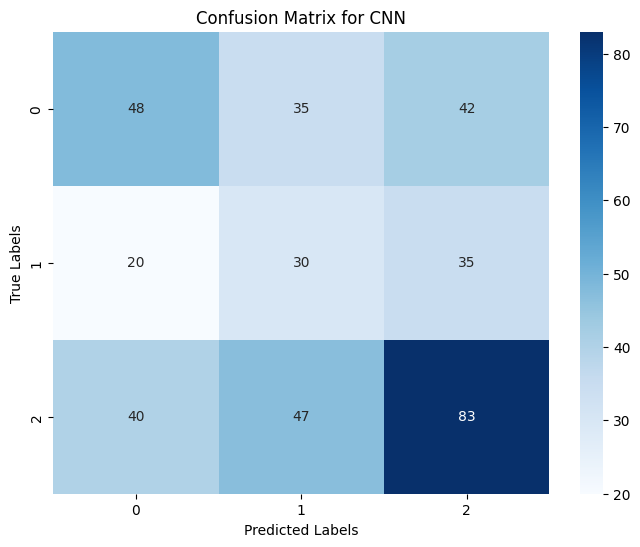

Metrics for FCNN:
Precision: 0.3879, Recall: 0.3840, F1 Score: 0.3841


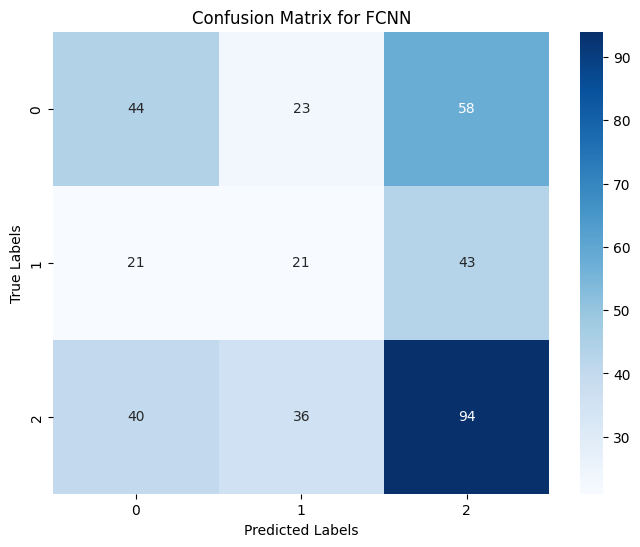

Metrics for SVM:
Precision: 0.3535, Recall: 0.4386, F1 Score: 0.3858


c:\Users\hrzha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


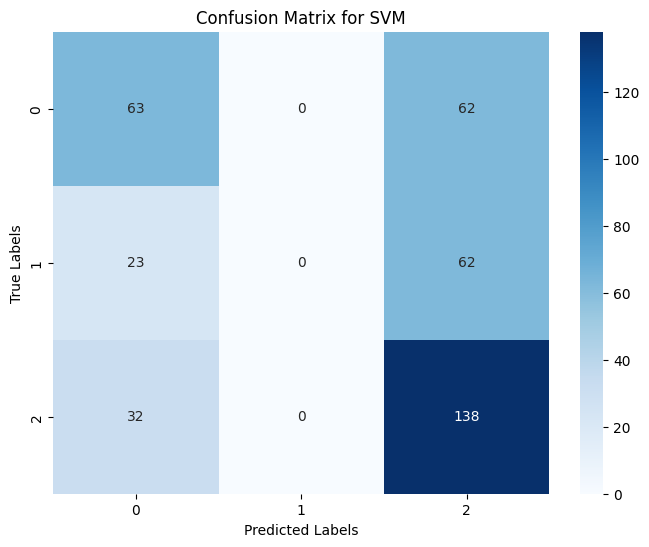

In [76]:
for model, name in [(cnn_model, 'CNN'), (fcnn_model, 'FCNN')]:
    actuals, predictions = get_predictions(model, test_loader)
    display_metrics(actuals, predictions, name)

svm_predictions = svm_model.predict(X_test_svm)
display_metrics(y_test_svm, svm_predictions, 'SVM')

# 2. Regression Models

### 2.1 Split Data

In [79]:
# This code is repeated from the classifcation section

# Load and prepare the data
# Home Gaol Difference is used in this section.
data = pd.read_csv('final_dataset.csv')
X = data.drop(['Match ID', 'Result', 'Home Goal Difference'], axis=1).values
y = data['Home Goal Difference']

# Split into train+val and test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

# Then split train+val into train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=11)

# Scale features (fit on training data, then transform train, val, and test sets)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors (note that y is now float and not long, as we are doing regression)
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values)

# Create datasets
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
val_dataset = CustomDataset(X_val_tensor, y_val_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

# Data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### 2.2 Initialize and Train Models

**Fully Connected Neural Network**

In [80]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [84]:
# Redeifine the FCNN model for regression

class FCNN(nn.Module):
    def __init__(self, input_size):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64) 
        self.fc2 = nn.Linear(64, 32)         
        self.fc3 = nn.Linear(32, 1)          # 1 neurons in the output layer, only for goal difference.

    def forward(self, x):                    # The forward function defines the forward pass of the model.
        x = torch.relu(self.fc1(x))          # The activation function used is ReLU for all hiudden layers.
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)                      # No activation function is applied to the output layer.
                                             # Softmax can be used to get the probabilities for each class, had we more time to improve this experiment.
        return x

In [85]:
# Redefinie train and validate functions for regression. The loss function is now Mean Squared Error.
def train(model, criterion, optimizer, loader):

    model.train()
    running_loss = 0.0

    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)  # Adjust for the output dimension
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(loader)

def validate(model, loader):

    model.eval()
    predictions, truths = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs).squeeze()
            predictions.extend(outputs.cpu().numpy())
            truths.extend(labels.cpu().numpy())

    mse = mean_squared_error(truths, predictions)
    rmse = sqrt(mse)
    return rmse

In [86]:
best_val_rmse = float('inf') # Initialize with infinity
best_model_state = None

model = FCNN(input_size=X_train_scaled.shape[1])
criterion = nn.MSELoss() # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101):
    train_loss = train(model, criterion, optimizer, train_loader)
    val_rmse = validate(model, val_loader)

    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_model_state = model.state_dict()
        print(f"Epoch {epoch}: New best model saved with validation RMSE: {best_val_rmse:.4f}")

# Save the best model state to a file
torch.save(best_model_state, './models/fcnn_regression_best_model.pth')

Epoch 1: New best model saved with validation RMSE: 1.8633
Epoch 2: New best model saved with validation RMSE: 1.8192
Epoch 3: New best model saved with validation RMSE: 1.7905
Epoch 4: New best model saved with validation RMSE: 1.7889
Epoch 6: New best model saved with validation RMSE: 1.7819


**Convolutional Neural Network:**

This was skipped since in the above classification section, we saw that the CNN did not meaningfully outperform the FCNN.

**Ridge Regression**

In [87]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV

model = Ridge()
parameters = {'alpha': np.logspace(-4, 4, 20)}

# Perform grid search
grid_search = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters and model
best_model = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)
print("Best RMSE from grid search:", np.sqrt(-grid_search.best_score_))

# Save the best model
joblib.dump(best_model, './models/ridge_regression_best_model.pkl')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'alpha': 1438.44988828766}
Best RMSE from grid search: 1.7433263413051154


['./models/ridge_regression_best_model.pkl']

### 2.3 Model Evaluation

In [92]:
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            predictions.extend(outputs.view(-1).tolist())  # Flatten the outputs and convert to list
            actuals.extend(targets.view(-1).tolist())
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    return rmse

In [94]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load and evaluate the Ridge regression model
ridge_model = joblib.load('./models/ridge_regression_best_model.pkl')

y_pred = best_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE, Ridge Regression:", test_rmse)

test_r2 = r2_score(y_test, y_pred)
print("Test R^2, Ridge Regression:", test_r2)

test_mae = mean_absolute_error(y_test, y_pred)
print("Test MAE, Ridge Regression:", test_mae)

# Evaluate FCNN Model
fcnn_model = FCNN(input_size=X.shape[1])
state_dict = torch.load('./models/fcnn_regression_best_model.pth')
fcnn_model.load_state_dict(state_dict)
fcnn_rmse = evaluate_model(fcnn_model, test_loader)
print("Test RMSE, FCNN:", fcnn_rmse)

Test RMSE, Ridge Regression: 1.686192550991023
Test R^2, Ridge Regression: 0.18092008980302599
Test MAE, Ridge Regression: 1.304157831599002
Test RMSE, FCNN: 2.3143795124610405
